# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

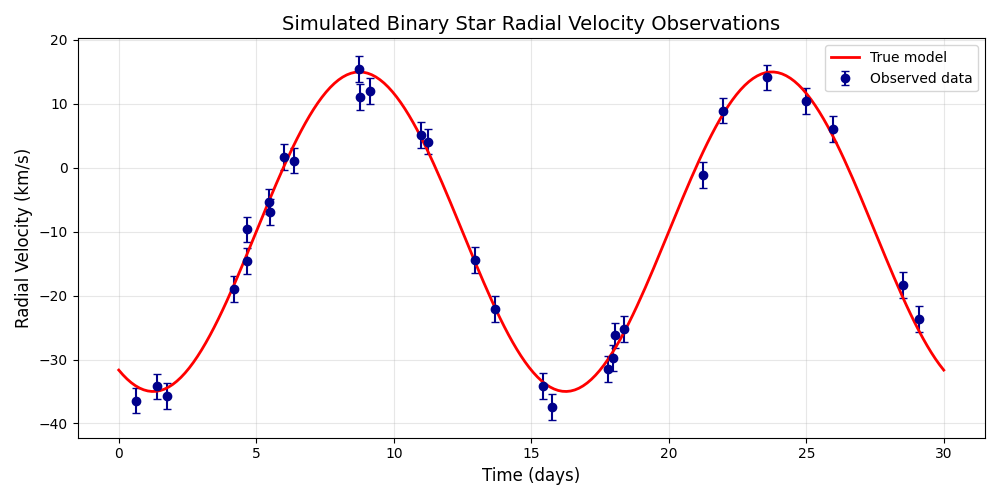

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [2]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [3]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    return np.sum(-.5*((v-radial_velocity_model( t, *theta))/v_err)**2)

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # you're doing this
    if theta[0] <= 0:
        return -np.inf
    if theta[1] <= 0:
        return -np.inf
    if theta[2] <= 0 or theta[2] > theta[1]:
        return -np.inf
    else:
        return 0
    

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    # you're doing this
    return log_likelihood(theta, t, v, v_err) + log_prior(theta)

#### Justify the choice of prior in a few sentences

I restrict amplitude (K) to be positive since, from my signal processing classes, we account for negative amplitude with a phase shift (t0).\
Period should obviously be positive.\
Since t0 is just a phase shift, we can say it's between 0 and P, since our function is a sine wave that repeats.\
v0 could realistically be anything.

#### Describe how you treated the uncertainties in a few sentences

In order to create our chi squared distribution for the log likelihood, I divide the square of the measurement uncertainties into the residuals.


#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [4]:
# MCMC setup
ndim = 4
nwalkers = 10
nsteps = 10000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.

guesses = np.array([K_true, P_true, t0_true, v0_true]) + np.random.randn(nwalkers, ndim)

#### Run the MCMC Sampler
This may take a minute or two.

In [5]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[t_obs, v_obs, v_err])
# Run MCMC
sampler.run_mcmc(guesses, nsteps, progress=True)
# Print the acceptance fraction from the sampler
print("Acceptance Fraction:", np.median(sampler.acceptance_fraction))

100%|██████████| 10000/10000 [00:03<00:00, 3148.72it/s]

Acceptance Fraction: 0.5923499999999999


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

Autocorrelation Time: 58.45788384185178


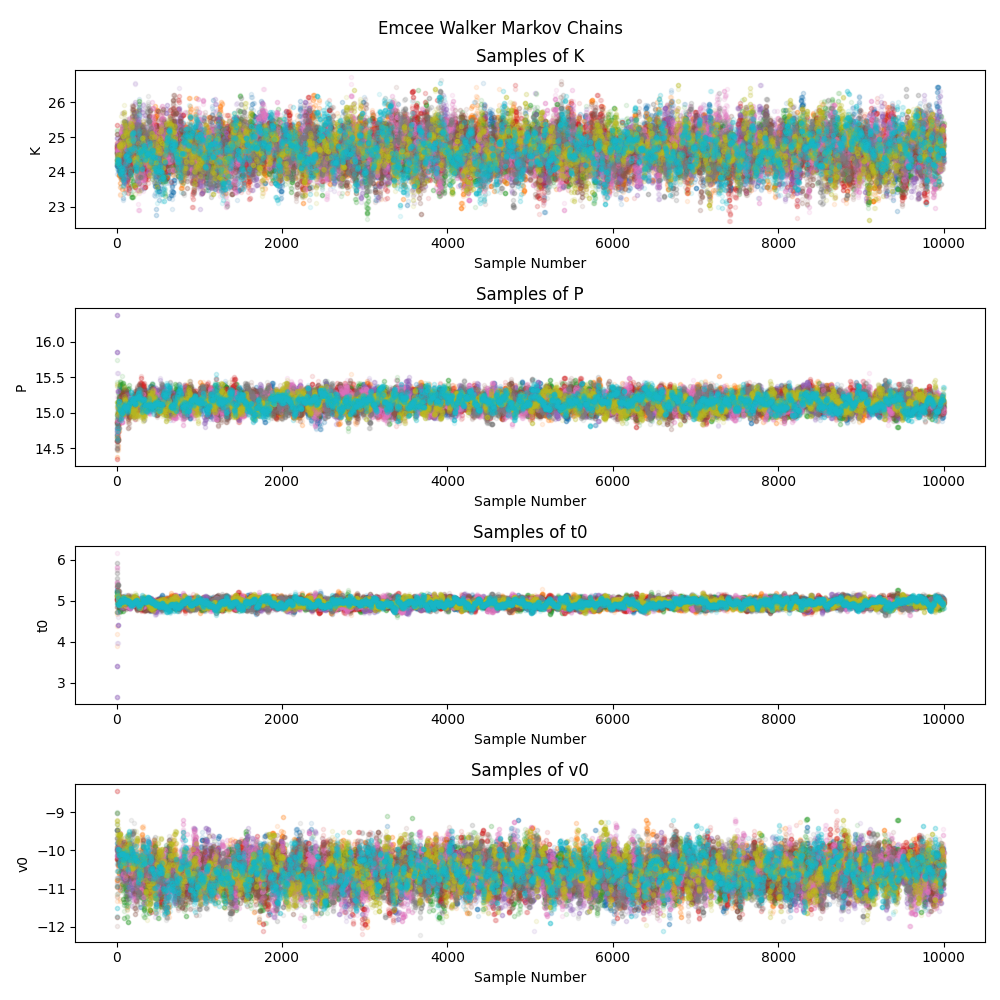

In [6]:
# Plot the chains - and remember to label your plots - you aren't silly first-years
labels = ['K', 'P', 't0', 'v0']
samples_init = sampler.get_chain()
plt.figure(figsize=(10, 10), layout='tight')
plt.suptitle("Emcee Walker Markov Chains")
for i in range(4):
        plt.subplot(4,1,i+1)
        for j in range(nwalkers):
            plt.plot(samples_init[:, j, i], '.', alpha=.1)
        plt.title(f'Samples of {labels[i]}')
        plt.ylabel(labels[i])
        plt.xlabel("Sample Number")

# Calculate autocorrelation time
auto_correlation = np.median(sampler.get_autocorr_time())
print("Autocorrelation Time:", auto_correlation)


#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [7]:
# Get flattened samples (discard burn-in and thin)
samples=sampler.get_chain(flat=True, thin=int(.5*auto_correlation), discard=int(2*auto_correlation))
# Calculate parameter estimates
K_est = np.median(samples[:,0])
K_std = np.std(samples[:,0])
P_est = np.median(samples[:,1])
P_std = np.std(samples[:,1])
t0_est = np.median(samples[:,2])
t0_std = np.std(samples[:,2])
v0_est = np.median(samples[:,3])
v0_std = np.std(samples[:,3])
print(f"Estimated value of K: {K_est:.3f}, Standard deviation: {K_std:.3f}, True value of K: {K_true} (km/s)")
print(f"Estimated value of P: {P_est:.3f}, Standard deviation: {P_std:.3f}, True value of P: {P_true} (days)")
print(f"Estimated value of t0: {t0_est:.3f}, Standard deviation: {t0_std:.3f}, True value of t0: {t0_true} (days)")
print(f"Estimated value of v0: {v0_est:.3f}, Standard deviation: {v0_std:.3f}, True value of v0: {v0_true} (km/s)")

Estimated value of K: 24.652, Standard deviation: 0.518, True value of K: 25.0 (km/s)
Estimated value of P: 15.152, Standard deviation: 0.100, True value of P: 15.0 (days)
Estimated value of t0: 4.949, Standard deviation: 0.076, True value of t0: 5.0 (days)
Estimated value of v0: -10.570, Standard deviation: 0.398, True value of v0: -10.0 (km/s)


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

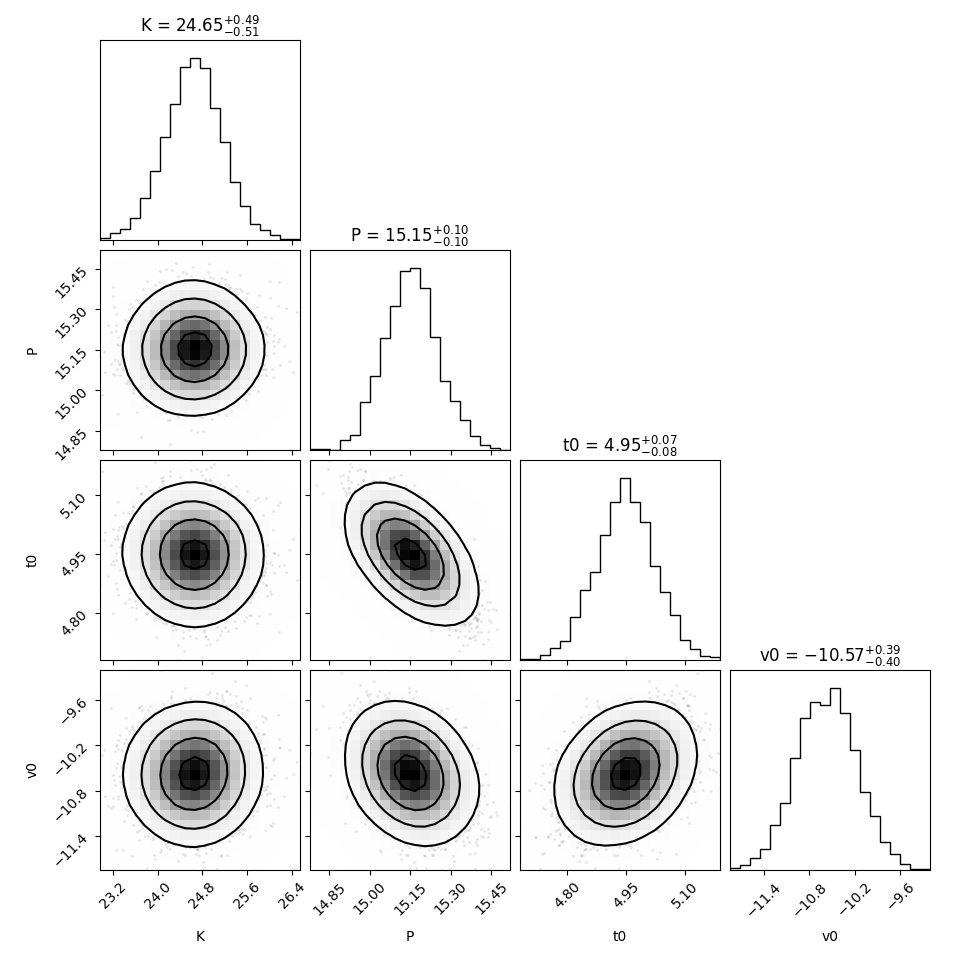

In [8]:
# you can use the corner package
fig = corner.corner(samples[:,:], plot_contours=True, show_titles=True, smooth=2, labels=labels) 

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

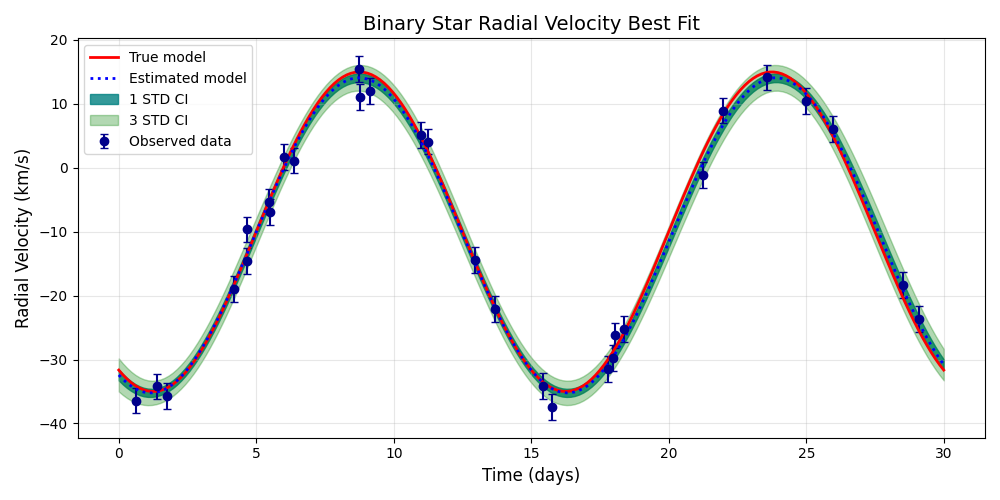

In [9]:
# also plot the true model - you can look at the simulation code
v_est_line = radial_velocity_model(t_model, K_est, P_est, t0_est, v0_est)
models = np.array([radial_velocity_model(t_model, *samples[i]) for i in range(len(samples))])
stds = np.array([np.std(models[:, i]) for i in range(len(t_model))])
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.plot(t_model, v_est_line, 'b:', label='Estimated model', linewidth=2)
plt.fill_between(t_model, v_est_line - stds, v_est_line + stds, color='teal', alpha=0.8, label='1 STD CI')
plt.fill_between(t_model, v_est_line - 3*stds, v_est_line + 3*stds, color='green', alpha=0.3, label='3 STD CI')
plt.plot()
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Binary Star Radial Velocity Best Fit', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

There is a strong negative correlation between t0 and P, a slight negative correlation between v0 and P, and a slight positive correlation between v0 and t0. K appears to be uncorrelated with everything. v0 decreasing with P makes sense, since something travelling slower should clearly take longer to orbit. Since t0 is just a phase shift, it's not entirely clear why it might be correlated with anything.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

Based on the medians and standard deviations, both K and t0 are within the error bars, but P and v0 are not. In the plot, the bottom peak and top peak are too low, indicating v0 is also too low, which is the case. Additionally, the functions line up at about t=16, but the fit appears wider than the model, indicating P is too high, which is also the case. K and t0 are a bit harder to tell, and those are each within 1 STD of the true values.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

By increasing v_err, our samples are clearly more scattered and have much larger error bars. As a result, we have a much worse fit and a much wider confidence interval.

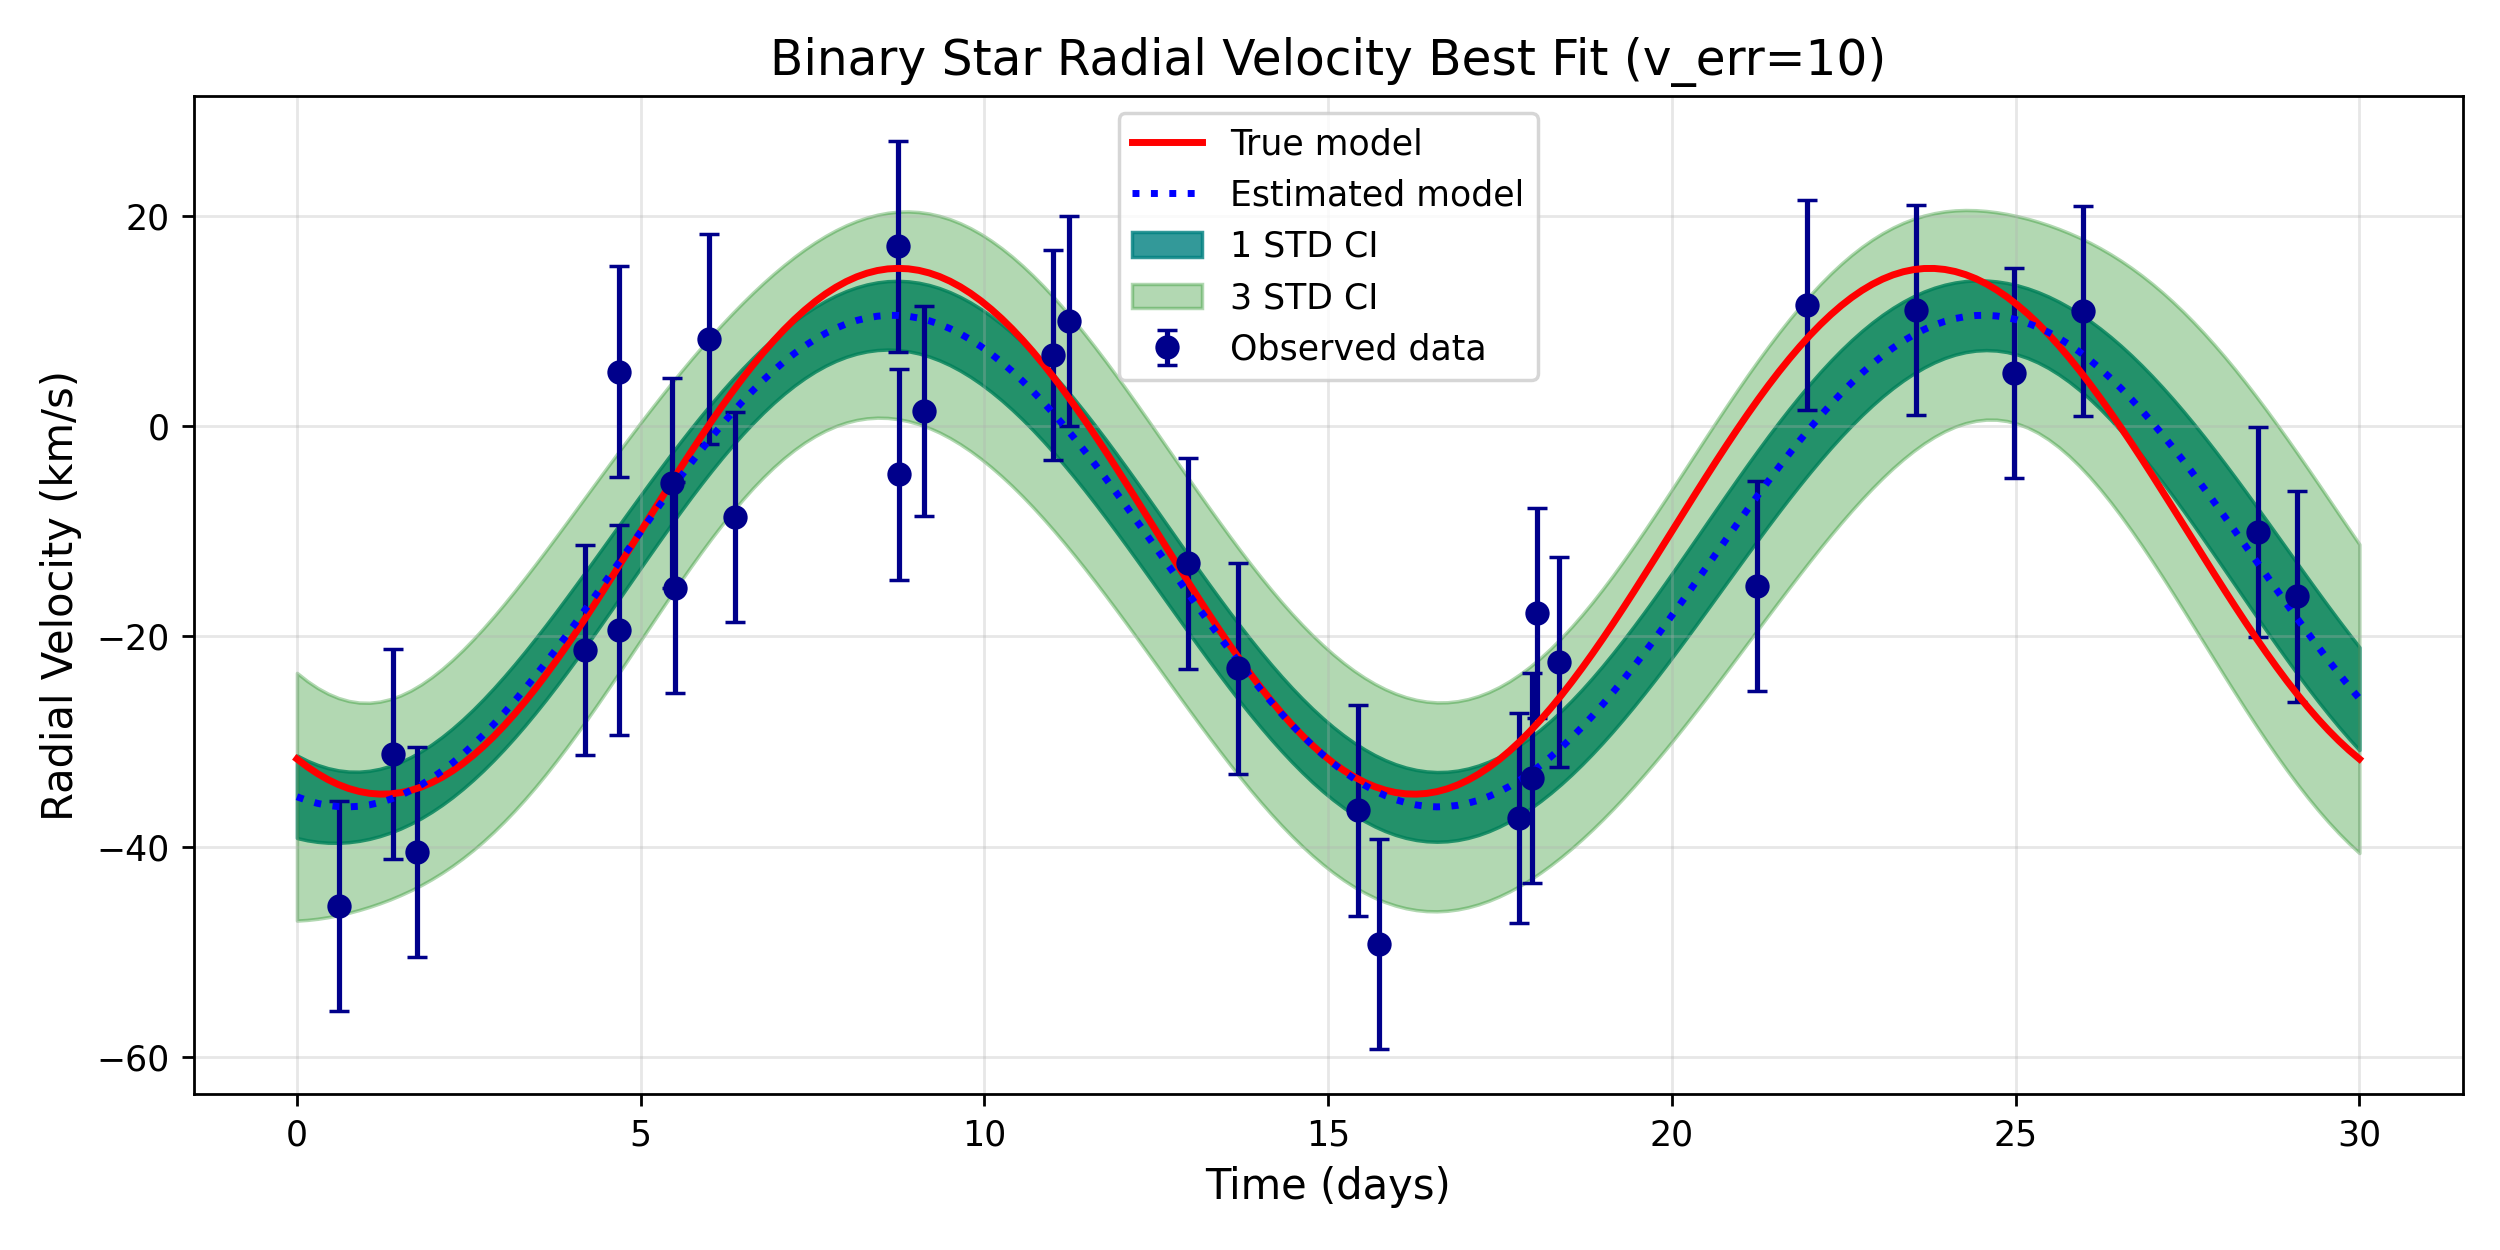

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?

I get an error if I set nwalkers too low, even if I use the parameter live_dangerously=True, which I really hoped would do something. Even if it did work, we may not be able to explore the full parameter space. If I set nsteps too low, and don't discard burn-in or thin my samples, we get samples that are heavily correlated, but the overall fit is still fairly accurate. The confidence interval is slightly wider, and this is likely because we have a higher proportion of samples farther from where the walkers converge than if we had more samples.

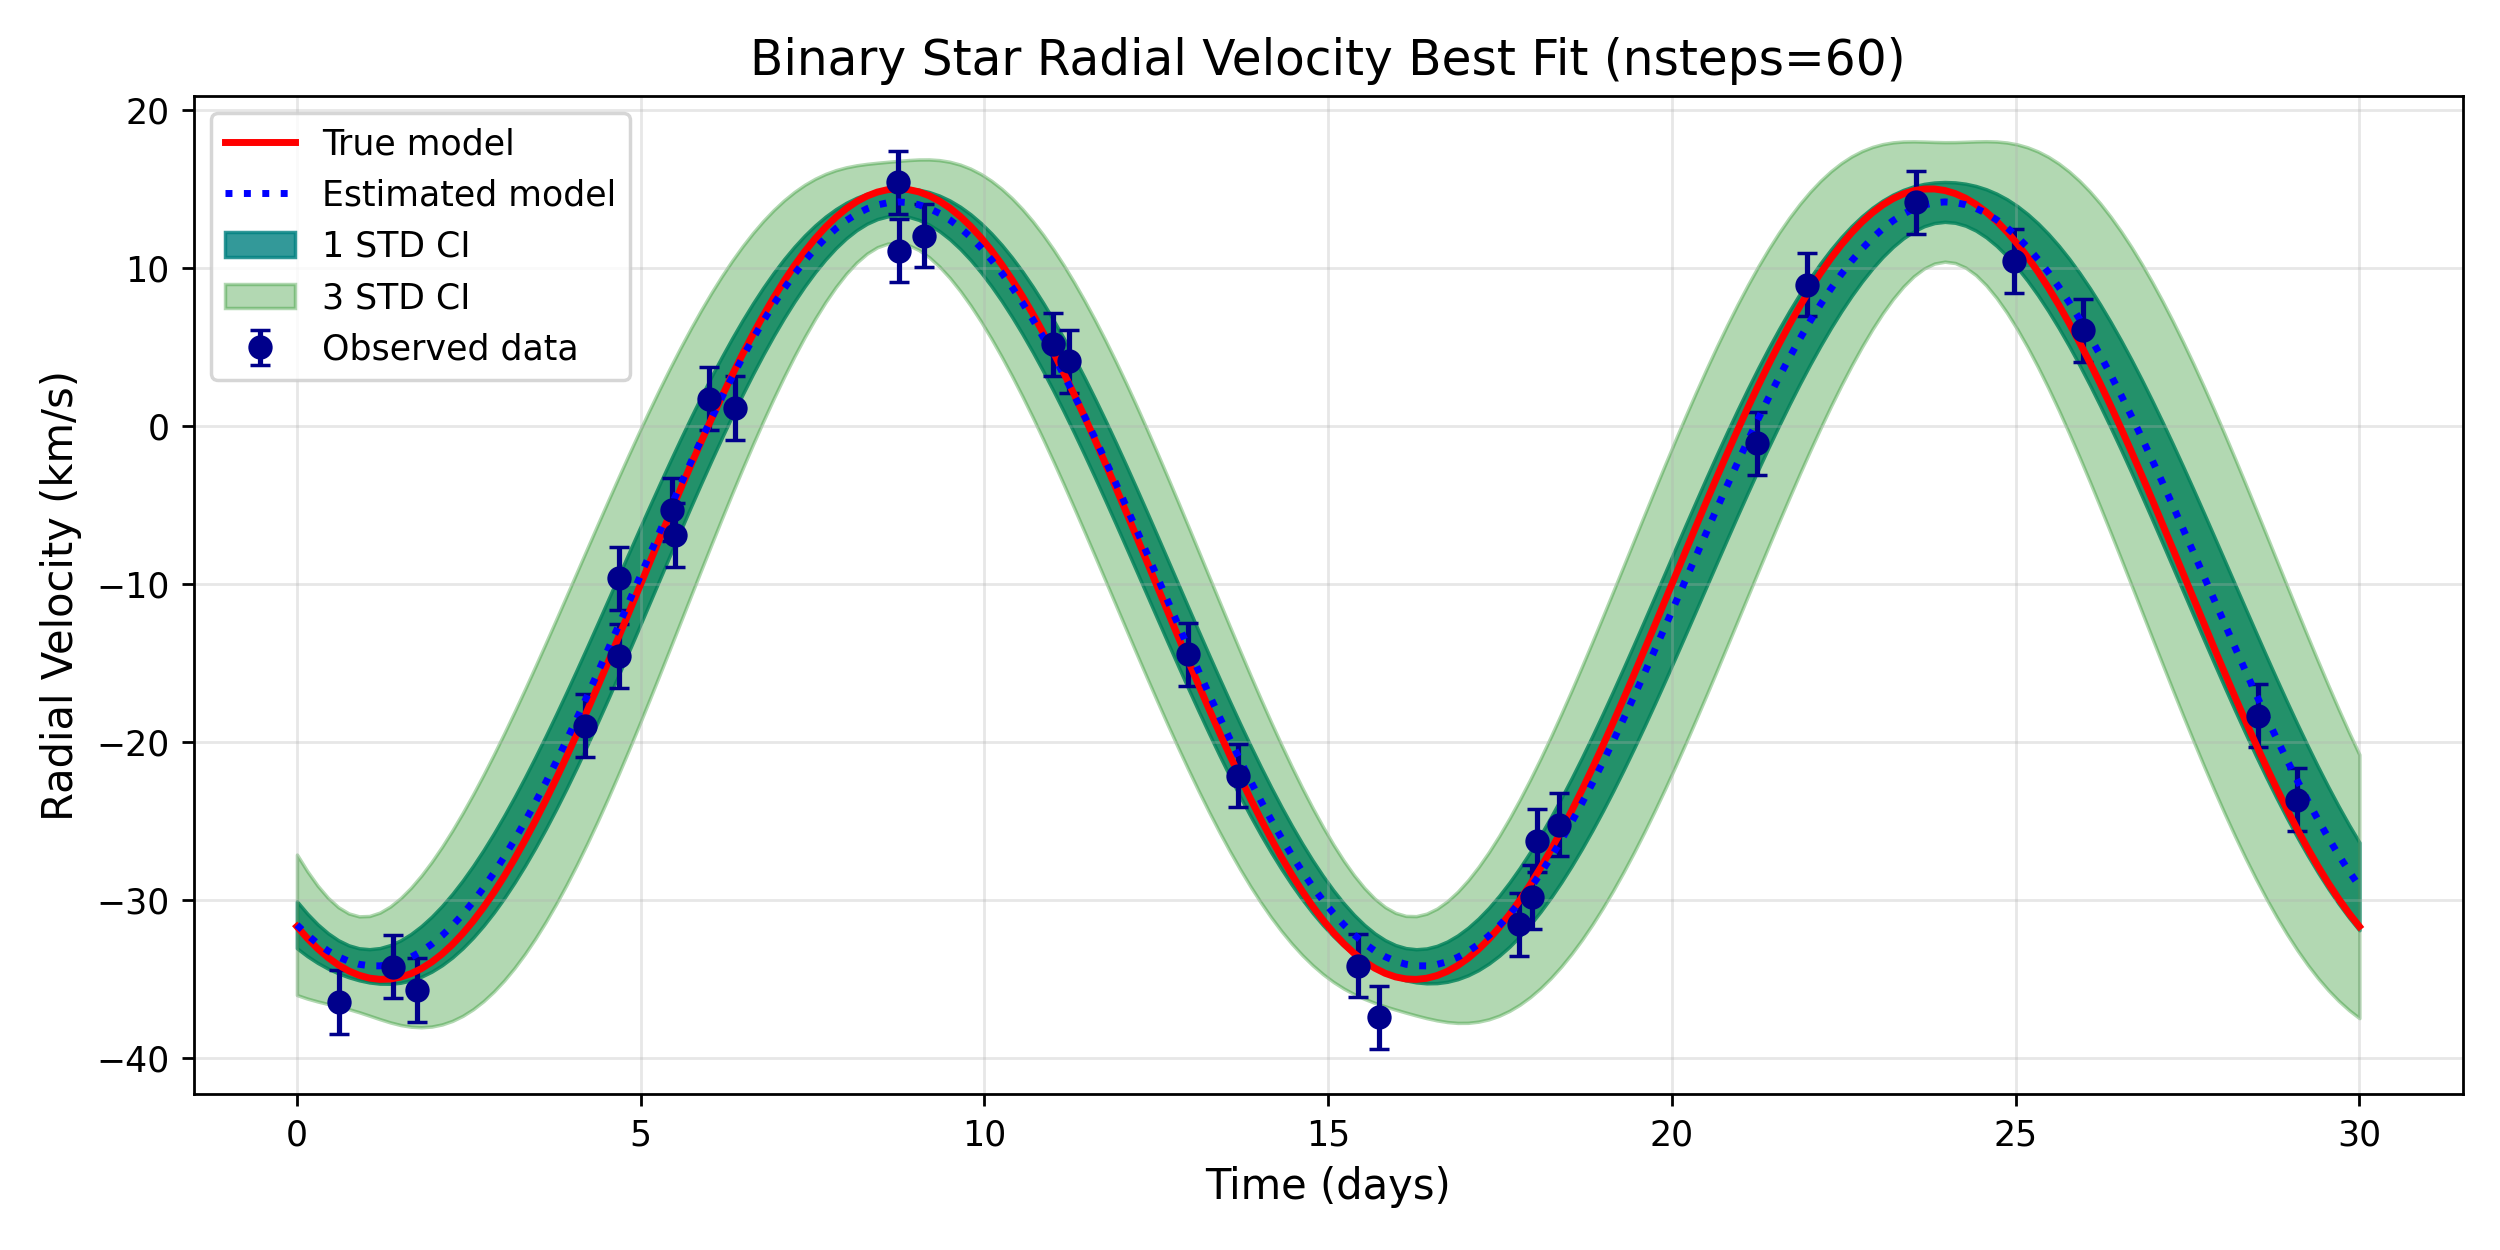
